# Turing Machine and Deep Learning

## Assignment 2: Supervised Classification Problems

This notebook is meant for you to review and reflect on the content of Lecture 2, which was mainly about supervised learning problems in the general context of classification. We will reflect mainly on model and hyperparameter selection over the models we have discussed during the lecture: logistic regression, decision trees, random forests and support vector machines. This notebook should not be too much quantitative work (lines of code) but keep in mind that running this notebook may take a longer time than you may be used to for python programs (*training good models take time!*)

### Handing in your Assignment

Git is an invaluable resource to researchers and developers, and thus for this course, all course material will be (additionally) shared on GitHub. Though there is a tiny bit of a learning curve, this is worth the effort. To hand in your assignment (applicable to all weeks):

1. Create a folder called "Week 2" and copy this notebook and any other files or data that may be needed.
2. Finish the notebook and commit and push regularly. Your final commit before the deadline will be graded.


# Question 1 -- Classification Metrics

To contextualise, we learnt of 4 metrics in class: accuracy, precision, recall and F1 score. Answer the following text questions in the following markdown cell.
1. For accuracy, precision and recall, mention one specific example *each* (i.e. a well-defined problem where ML can be used) where they would be preferable.
2. For accuracy, precision and recall, mention one specific example *each* (i.e. a well-defined problem where ML can be used) where they would fail.
3. In which situations would the F1 score be helpful? Give one concrete example.

Accuracy: Email spam classification where correctly identifying all spam emails is crucial.
Precision: Sentiment analysis in social media posts where identifying positive sentiment accurately is important.
Recall: Medical diagnosis of a life-threatening condition where identifying all positive cases is critical.

Accuracy: Imbalanced datasets where the majority class dominates, leading to misleadingly high accuracy.
Precision: Anomaly detection in network traffic where the occurrence of false positives could overshadow true anomalies.
Recall: Identifying rare adverse drug reactions where false negatives could have serious consequences.

The F1 score is helpful in situations where both precision and recall are equally important, such as in binary classification tasks where there is an imbalance between positive and negative classes. For example, in a medical diagnosis scenario where detecting both true positives and minimizing false negatives are equally crucial for patient care.

## Question 2 -- CIFAR 10

As we've discussed last week, one of the prime issues with ML is figuring out what model you are going to use and when. In this case, we're going to use the [CIFAR-10](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10) dataset from TensorFlow, another benchmarking dataset. This is a considerably larger dataset, and contains coloured images. For the sake of computation time, we are just going to use the first 1000 training images but the full test set (though in a proper ML setting we would prefer to use all training data). The images are 32x32 coloured pixes. There are 10 labels which are integers by default. The dictionary `class_labels` translate them to their text label equivalents (referenced from [here](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data)).

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 47s 0us/step


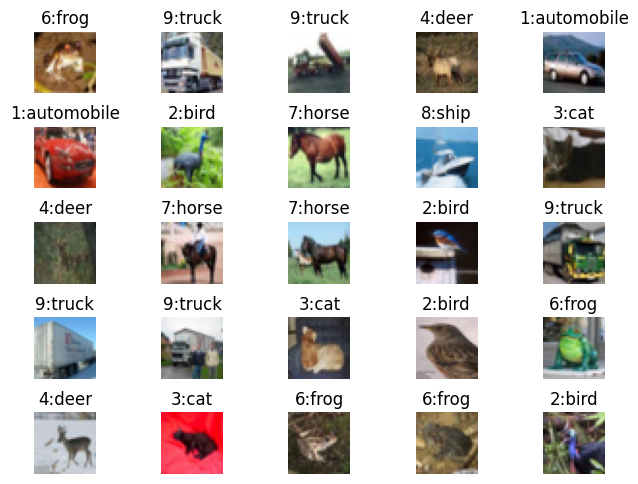

In [6]:
# don't need to edit anything here,
# just run this cell

# get dataset
from tensorflow.keras.datasets import cifar10
# get common libraries
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm # this is a new one: makes loading bars

def get_data_subset(n_train, n_test):
    (train_X, train_y), (test_X, test_y) = cifar10.load_data()
    train_X, train_y, test_X, test_y = train_X[:n_train], train_y[:n_train], test_X[:n_test], test_y[:n_test]
    train_y, test_y = train_y.squeeze(), test_y.squeeze()
    return train_X, train_y, test_X, test_y

n_train, n_test = 1000, 1000

train_X, train_y, test_X, test_y = get_data_subset(n_train, n_test)

fig, axs = plt.subplots(5,5)
axs = axs.flatten()
fig.tight_layout(pad=0.3)

class_labels = {0:"airplane",
                1:"automobile",
                2:"bird",
                3:"cat",
                4:"deer",
                5:"dog",
                6:"frog",
                7:"horse",
                8:"ship",
                9:"truck"}

for i, ax in enumerate(axs):
    ax.imshow(train_X[i])
    ax.set_title(f"{train_y[i]}:{class_labels[train_y[i]]}")
    ax.axis("off")

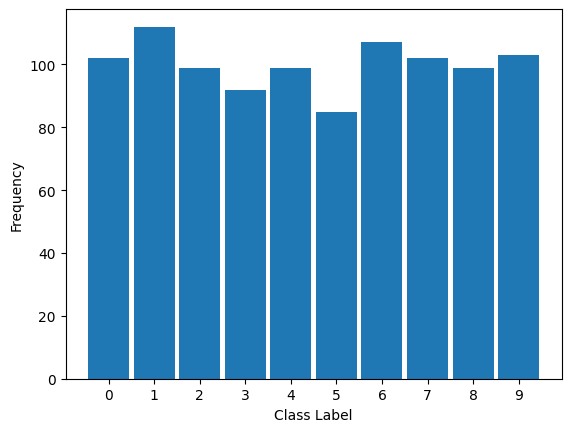

In [7]:
# making sure the quantity of examples for each label are about the same
plt.hist(train_y, bins=10, rwidth=0.9)
plt.xticks(0.9*np.arange(10)+0.45, range(10))
plt.ylabel("Frequency")
plt.xlabel("Class Label")
plt.show()

## Question 2.1 -- Preprocessing

The first thing we should do is preprocess the images so that they are ready to be input into our models. First, print out the shape of the dataset's inputs (`train_X`).

In [8]:
print(train_X.shape)

(1000, 32, 32, 3)


**Q 2.1.1** What does each value in the tuple that was printed out mean?

1000: the number of samples in the training set
32: the height of each image in pixels
32: the width of each image in pixels
3: the number of color channels in each image (red,green or blue, ie, RGB)

**Q 2.1.2** Next, flatten the pixel values to a single vector. What is the length of this vector? Print out the shape of the flattened dataset's inputs once more.

In [11]:
# Your answer here
def flatten_cifar10(samples):
    return samples.reshape(samples.shape[0], -1)

train_X, test_X = flatten_cifar10(train_X), flatten_cifar10(test_X)

## Question 3 -- Model Selection using Grid Search

In the lecture, we have seen four different ML classification algorithms: logistic regression, decision trees, random forests and support vector machines. In this assignment, we will figure out which is best, and a basic method to figure out the best way to tune the parameters of each one. Remember, a hyperparameter is something that you choose by hand about the model or the way it trains.

### Question 3.1 -- Logistic regression

Use `sklearn` (as in the lecture notebook) to classify the CIFAR10 sub-dataset. There are not a lot of major hyperparameters to tune here, so this exercise should be straightforward. Create a LogisticRegression object, fit it on the training data, and compute the train and test accuracies.

*Expected runtime: ~1min*

In [12]:
from sklearn.linear_model import LogisticRegression

modelLR =  LogisticRegression(max_iter=1000) # create the logistic regression object
modelLR = modelLR.fit(flatten_cifar10(train_X), train_y)
 # fit on training data
print("Training score:", modelLR.score(flatten_cifar10(train_X), train_y))
print("Testing score: ", modelLR.score(flatten_cifar10(test_X), test_y))

Training score: 1.0
Testing score:  0.246


**Q 3.1.2** Does the model work well in your opinion? What about whether it is over/underfitting?

The testing score is not close to the training score, we can infer that the model does not generalize well. Then it is likely to be overfitting.

### Question 3.2 -- Decision Trees

Decision trees have one main hyperparameter that you can tune -- this is the maximum depth of the tree being trained. Thus, we'll try and figure out what depth is the optimal for our purposes.

An important thing to note is that decision trees are randomized initially -- this means that two trees of the same depth may have wildly different performances, depending on how they were initialized.

**Q 3.2.1** Loop over max tree depths from $d=1$ to $d=15$ and store the mean and standard deviation of train and test scores for 10 randomly initialised trees.

*Expected runtime: <5 mins*

In [15]:
from sklearn import tree

train_acc_mean, train_acc_std = [], [] # to store the training accuracies
test_acc_mean, test_acc_std = [], []   # to store the testing accuracies

for d in tqdm(range(1,16)): # loop over tree depths
    train_perfs = [] # store interem train scores
    test_perfs = []  # store interem test scores
    for n in range(10):   # loop over random initializations
       # Initialize new decision tree model
        modelDT = tree.DecisionTreeClassifier(max_depth=d)
        
        # Train the model
        modelDT.fit(flatten_cifar10(train_X), train_y)
        
        # Calculate train and test scores
        train_score = modelDT.score(flatten_cifar10(train_X), train_y)
        test_score = modelDT.score(flatten_cifar10(train_X), test_y)
        
        # Store interim values
        train_perfs.append(train_score)
        test_perfs.append(test_score)

    # append mean and std scores to appropriate lists
    train_acc_mean.append(np.mean(train_perfs))
    train_acc_std.append(np.std(train_perfs))
    test_acc_mean.append(np.mean(test_perfs))
    test_acc_std.append(np.std(test_perfs))


  0%|          | 0/15 [00:00<?, ?it/s]

 67%|██████▋   | 10/15 [06:57<03:28, 41.79s/it]


KeyboardInterrupt: 

**Q 3.2.2** Plot the test and train means with errorbars equal to one standard deviation (look at [plt.errorbar](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.errorbar.html) for reference). Don't forget to add labels.

In [ ]:
plt.errorbar(range(1, 16), test_acc_mean, yerr=test_acc_std, label='Test', fmt='-o')
plt.errorbar(range(1, 16), train_acc_mean, yerr=train_acc_std, label='Train', fmt='-o')
plt.title('Mean Accuracy with Standard Deviation Error Bars')
plt.ylabel('Accuracy')
plt.xlabel('Maximum Tree Depth')
plt.legend()
plt.grid()
plt.show()

**Q 3.2.3**

1. Is there a lot of variation of the performance of the trees (enough to question statistical significance)?
2. Which model (of the ones you tested) performed best on the training set? Which performed best on the test set?
3. At what depth do models start to overfit the training data?

I do not know because cell 15 has been running for minutes without any output and I can't figure out the problem.

## Question 3.3 -- Random Forests
Just like in the decision trees, one hyperparameter you can choose is the depth of the tree. However, another important one is the number of decision trees. In this case, the performance is affected by the combination of these hyperparameters, and so we need to train and evaluate them at each combination.

**Q 3.3.1** Loop over $n_{trees}=10$ to $n_{trees}=100$ in increments of 10, and max tree depths from $d\in[1,3,5,7,9,11,13,15]$ and store the mean and standard deviation of train and test scores for 5 randomly initialised trees.

*Expected runtime: ~9 minutes*

In [17]:
from sklearn.ensemble import RandomForestClassifier as RFC


train_acc_mean = np.zeros((10, 8))  # storing it in an np array instead of a list makes it easier
train_acc_std = np.zeros((10, 8))
test_acc_mean = np.zeros((10, 8))
test_acc_std = np.zeros((10, 8))

n_trees = np.arange(10, 110, 10)
depths = [1, 3, 5, 7, 9, 11, 13, 15]

for tree_idx, n_tree in tqdm(enumerate(n_trees), total=len(n_trees)):
    for d_idx, d in enumerate(depths):
        train_perfs = []
        test_perfs = []
        for n in range(5):  # 5 random initializations
            # Initialize new random forest model
            modelRF = RFC(n_estimators=n_tree, max_depth=d)
            
            # Train the model
            modelRF.fit(flatten_cifar10(train_X), train_y)
            
            # Calculate train and test scores
            train_score = modelRF.score(flatten_cifar10(train_X), train_y)
            test_score = modelRF.score(flatten_cifar10(test_X), test_y)
            
            # Store interim values
            train_perfs.append(train_score)
            test_perfs.append(test_score)
        
        # Store mean and std scores
        train_acc_mean[tree_idx][d_idx] = np.mean(train_perfs)
        train_acc_std[tree_idx][d_idx] = np.std(train_perfs)
        test_acc_mean[tree_idx][d_idx] = np.mean(test_perfs)
        test_acc_std[tree_idx][d_idx] = np.std(test_perfs)


  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [02:15<09:01, 67.68s/it]


KeyboardInterrupt: 

Looping over several variables and testing each combination is called a **grid search**. Since we have two hyperparameters, we cannot plot a 1D line to see which is best, as we did for normal DTs. One way to visualize this instead is a heatmap. For this, we can `seaborn`'s [heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html) function.  

**Q 3.3.2** Plot two heatmaps: one for the train accuracies and one for the test ones.

In [ ]:
import seaborn as sns

# Figure 1 - Train Accuracies Heatmap
plt.figure()
sns.heatmap(train_acc_mean, annot=True, xticklabels=depths, yticklabels=n_trees)
plt.title('Train Accuracies Heatmap')
plt.xlabel('Max Tree Depth')
plt.ylabel('Number of Trees')
plt.show()

# Figure 2 - Test Accuracies Heatmap
plt.figure()
sns.heatmap(test_acc_mean, annot=True, xticklabels=depths, yticklabels=n_trees)
plt.title('Test Accuracies Heatmap')
plt.xlabel('Max Tree Depth')
plt.ylabel('Number of Trees')
plt.show()


**Q 3.3.2**
1. What trends with respect to each hyperparameter do the heatmaps show you?
2. What model performs best on the train set? What model performs best on the test set?
3. What model would you choose to deploy and why?

It runs and runs without an output so I can not answer the questions :( I could not figure out why it won't stop.

## Question 3.4 -- Support Vector Machines

`sklearn`'s SVM classifier implementation (called "SVC", we already met them in the lecture) contains quite a number of hyperparameters you can tune. The ones we are looking at today are the kernel, the parameter `C` (which is some penalty term for incorrectly classifying a data point, applicable to the RBF kernel), `gamma`, which is a measure of how important closer points to the decision boundary are with respect to the decision boundary (applicable to the RBF kernel), and `degree`, which is the degree of the polynomial function (applicable to the poly kernel). Let $C\in\{0.1, 1, 10, 100\}$ and $gamma\in\{10^x|-2\leq x\leq 2, x\in\mathbb{Z}\}$. Let us use $degree\in\{2,3,4\}$.

A note about the kernel: In short, this is a function that determines what the shape of the decision boundary are. The choices that we can check out here (there are more) are `linear` (linear decision boundary), `poly` (polynomial) and `rbf` (radial basis function) in order of flexibility.

Since we are trying to optimize for a number of different parameters, writing out all the code ourselves gets a bit messy. Instead, we use `sklearn` again! The class in question is called `GridSearchCV`, which performs a grid search over parameters with specified values.

The 'CV' part of the name refers to the fact that we are performing *cross-validation*, which is related to the concept of validation sets that we encountered last week. We will cover it in a future lecture, but for now, the way it works is that it splits the training set into $k$ sets (called 'folds') and iteratively trains on $k-1$ folds and validates on the remaining one. The result is the mean over $k$ iterations. CV is considered the 'gold standard' with respect to analysing model robustness. We will use $k=5$ (appropriately called *5-fold cross-validation*), which is standard for a first analysis.

**Q 3.4.1** Run a gridsearch with 5-fold cross-validation over the hyperparameters discussed above to find an optimal SVC model. Please look at GridSearchCV's documentation for more information.

*Expected runtime: Around 15 minutes if you're lucky.*

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid_svm = [
    {'kernel': ['linear', 'poly', 'rbf'],
     'C': [0.1, 1, 10, 100],
     'degree': [2, 3, 4],
     'gamma': [10**x for x in range(-2, 3)]}
]

# Create the cross-validation object
optimal_params_svm = GridSearchCV(
    estimator=SVC(),             # Support Vector Classifier instance
    param_grid=param_grid_svm,   # Grid search parameters
    cv=5,                        # 5-fold cross-validation
    scoring='accuracy'           # Use accuracy measure for best hyperparameters
)

optimal_params_svm.fit(flatten_cifar10(test_X), train_y)

print(
    "The best parameters are %s with a score of %0.2f"
    % (optimal_params_svm.best_params_, optimal_params_svm.best_score_)
)


KeyboardInterrupt: 

**Q 3.4.2**
1. How many combinations of parameters are there? Why?
2. Using 5-fold validation, how many models do you train in total?

1. There are 3 x 4 x 3 x 5 = 180 combinations for parameters because we have 3 ways to pick kernel, 4 ways to pick C, 3 ways to pick the degree and 5 ways to pick gamma

2. We train 5 x 180 = 900 models because for each combination of parameters, the training set is split into 5 folds for cross-validation, resulting in 5 models trained per combination.

**Q 3.4.3**
Create a model `modelSVC` with the optimal parameters you found above and print out the train and test accuracies.

In [19]:
from sklearn.svm import SVC

#this is what I would have done if the cell above ran and I had optimal parameters.

modelSVC = SVC(kernel=optimal_params_svm.best_params_['kernel'],
               C=optimal_params_svm.best_params_['C'],
               degree=optimal_params_svm.best_params_['degree'],
               gamma=optimal_params_svm.best_params_['gamma'])

# Train model
modelSVC.fit(flatten_cifar10(train_X), train_y)

# Print out train and test accuracies
train_score_SVC = modelSVC.score(flatten_cifar10(train_X), train_y)
test_score_SVC = modelSVC.score(flatten_cifar10(train_X), test_y)

NameError: name 'optimal_params_svm' is not defined

## Question 4 -- Training and inference speed
Depending on the application, the choice of model may be affected by more than just the raw score. One of these factors is *time* -- specifically, how long does the model take to train, and how long does it take to make a prediction. In this case we're increasing the number of training points to 5000.

**Q 4.1** Create models with the  that you found above, measure how long it takes for it to train and classify images from the test and train set, along with their accuracies (a classification, or a single run of a model, is generally called an 'inference'). We generally store time with an action taken (fit or inference) *per image* and the inference times *per image*.

*Runtime: ~3mins*

In [27]:
from time import perf_counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier



n_train, n_test = 5000, 1000  # Adjust the number of training and testing samples as needed

# Get data
train_X, train_y, test_X, test_y = get_data_subset(n_train, n_test)
flattened_train_X = flatten_cifar10(train_X)
flattened_test_X = flatten_cifar10(test_X)

# Set up lists to store scores and times
train_scores = []
test_scores = []
fit_times = []
inf_times = []

def train_and_eval(model, train_X, train_y, test_X, test_y):
    """Trains, times and evaluates a given instantiated model on data"""
    start = perf_counter()  # Check current (start) time
    model.fit(train_X, train_y)  # Train the model
    end = perf_counter()  # Check current (end) time
    fit_time = (end - start) / len(train_X)  # Compute interval per image

    # Time inference over train score
    start = perf_counter()
    train_score = model.score(train_X, train_y)  # Compute train score
    end = perf_counter()
    train_score_time = (end - start) / len(train_X)  # Compute inference time per image

    # Time inference over test score
    start = perf_counter()
    test_score = model.score(test_X, test_y)  # Compute test score
    end = perf_counter()
    test_score_time = (end - start) / len(test_X)  # Compute inference time per image

    return train_score, test_score, fit_time, train_score_time, test_score_time

# Create models
modelLR = LogisticRegression(max_iter=1000)
modelDT = DecisionTreeClassifier(max_depth=10)
modelRFC = RandomForestClassifier(n_estimators=100, max_depth=10)
modelSVC = SVC(kernel='rbf', C=100, gamma=0.01)

models = [modelLR, modelDT, modelRFC, modelSVC]

for model in tqdm(models):
    train_score, test_score, fit_time, train_score_time, test_score_time = train_and_eval(model, flattened_train_X, train_y, flattened_test_X, test_y)
    # Add these values to the lists
    train_scores.append(train_score)
    test_scores.append(test_score)
    fit_times.append(fit_time)
    inf_times.append((train_score_time, test_score_time))


  0%|          | 0/4 [00:00<?, ?it/s]c:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 4/4 [06:47<00:00, 101.89s/it]


Plot two barplots:
1. **Q 4.2** On one, plot a dual barplot showing the test and train accuracies.
2. **Q 4.3** On the other, plot a double barplot showing the training time *per image* and the inference times *per image* (so divide the total time by the number of images).

For each, make sure you don't forget the unit of measurement, add a title and axis labels and make sure there are labels and a legend.

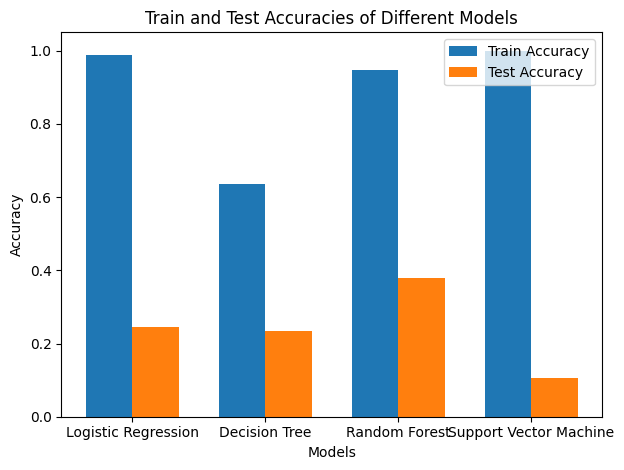

In [28]:
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Support Vector Machine']
bar_width = 0.35

# Create an array for the x-axis positions
x = np.arange(len(model_names))

# Plotting the bars
fig, ax = plt.subplots()

# training accuracy: don't forget to add labels
bar1 = ax.bar(x - bar_width/2, train_scores, bar_width, label='Train Accuracy')

# testing accuracy
bar2 = ax.bar(x + bar_width/2, test_scores, bar_width, label='Test Accuracy')

# Add labels, title, and legend
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Train and Test Accuracies of Different Models')
# set proper x ticks: I'll help you with this one
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()

plt.tight_layout()
plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (4,) and arg 1 with shape (4, 2).

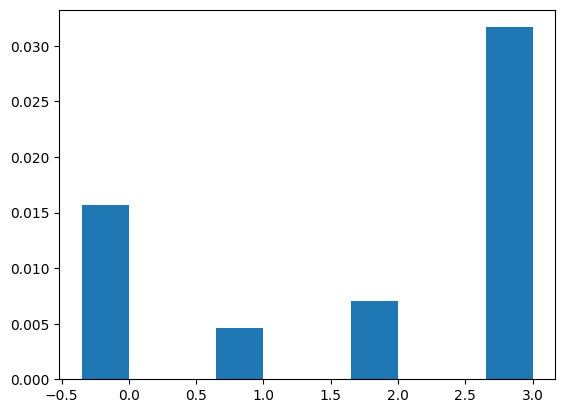

In [30]:
# Plotting the times
fig, ax = plt.subplots()

# fit times: don't forget labels
bar1 = ax.bar(x - bar_width/2, fit_times, bar_width, label='Training Time per Image')

# inference times
bar2 = ax.bar(x + bar_width/2, inf_times, bar_width, label='Inference Time per Image')

# Add labels, title, and legend
# set proper x ticks

ax.set_xlabel('Models')
ax.set_ylabel('Time (seconds)')
ax.set_title('Training and Inference Times per Image of Different Models')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()

plt.tight_layout()
plt.show()

**Q 4.4**
1. What model is the fastest to train?
2. What model is fastest to infer?
3. What model has the highest train accuracies? What model has the highest test accuracies?
4. What model would you choose to use? Why?



1. The logistic regression model is the fastest to train because it solves a conves optimisation problem with a closed-form solution.

2. The decision tree model is fastest to infer because the inference involves following the root node to a leaf node based on the features of the input.


3. The support vector machine (SVM) model has the highest train accuracies, while the random forest model has the highest test accuracies. This is because SVM tries to find the optimal margin of seperation in seperating classes which can lead to better fitting

4. If training time is the most valuable in our application, logistic regression could be preferred. If we value inference time the most, the decision tree model could be chosen. If high accuracy is our main goal, SVM or random forest models can be chosen.